In [12]:
from os import listdir
from scipy import signal
from itertools import combinations, product
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import truncation
import handle

def timestat_acc(acc_t):
    appended1, cov, pear = [], [], []
    Lx, Ly, Lz = [], [], []
    
    for t in acc_t:
        # appending number of zero crossing
        L1 = t['x'].values.tolist()
        ar_x = np.array(L1)
        zcross_xa = ((ar_x[:-1] * ar_x[1:]) < 0).sum()
       
        L2 = t['y'].values.tolist()
        ar_y = np.array(L2)
        zcross_ya = ((ar_y[:-1] * ar_y[1:]) < 0).sum()
        
        L3 = t['z'].values.tolist()
        ar_z = np.array(L3)
        zcross_za = ((ar_z[:-1] * ar_z[1:]) < 0).sum()
        
        Lx.append(ar_x)
        Ly.append(ar_y)
        Lz.append(ar_z)
        appended1.append([zcross_xa, zcross_ya, zcross_za])
        appended1.append([np.mean(L1), np.mean(L2), np.mean(L3)])
        appended1.append([np.std(L1), np.std(L2), np.std(L3)])
        
        # appending number of mean crossing
        xcrossings_a, ycrossings_a, zcrossings_a = [], [], []
        for i in range(1, len(ar_x)):
            if ar_x[i-1] < np.mean(L1) and ar_x[i] >= np.mean(L1):
                xcrossings_a.append(i)
            if ar_y[i-1] < np.mean(L2) and ar_y[i] >= np.mean(L2):
                ycrossings_a.append(i)
            if ar_z[i-1] < np.mean(L3) and ar_z[i] >= np.mean(L3):
                zcrossings_a.append(i)
                
        appended1.append([len(xcrossings_a), len(ycrossings_a), len(zcrossings_a)])
    
    # calculating covariance
    for j in range(len(Lx)):
        # setting conditions to deducting corresponding mean values from the array of different tries
        Lxi = Lx[j] - appended1[4*j+1][0]
        Lyi = Ly[j] - appended1[4*j+1][1]
        Lzi = Lz[j] - appended1[4*j+1][2]

        # using combination to calculate SOP of values divided by the number of values
        for i in combinations([Lxi,Lyi,Lzi],2):
            for x,y in [i]:
                pear.append((sum(x*y)/(len(Lxi)-1)) / (np.std(x) * np.std(y)))
                cov.append(sum(x*y)/(len(Lxi)-1))
                
    return appended1,cov,pear
    
def timestat_gyr(gyro_t):
    appended2, cov, pear = [], [], []
    L_x, L_y, L_z = [], [], []
    
    for t in gyro_t:
        L4 = t['x-axis (deg/s)'].values.tolist()
        ar_x = np.array(L4)
        zcross_xg = ((ar_x[:-1] * ar_x[1:]) < 0).sum()
        
        L5 = t['y-axis (deg/s)'].values.tolist()
        ar_y = np.array(L5)
        zcross_yg = ((ar_y[:-1] * ar_y[1:]) < 0).sum()
        
        L6 = t['z-axis (deg/s)'].values.tolist()
        ar_z = np.array(L6)
        zcross_zg = ((ar_z[:-1] * ar_z[1:]) < 0).sum()
        
        L_x.append(ar_x)
        L_y.append(ar_y)
        L_z.append(ar_z)
        appended2.append([zcross_xg, zcross_yg, zcross_zg])
        appended2.append([np.mean(L4), np.mean(L5), np.mean(L6)])
        appended2.append([np.std(L4), np.std(L5), np.std(L6)])
        
        xcrossings_g, ycrossings_g, zcrossings_g = [], [], []
        for i in range(1, len(ar_x)):
            if ar_x[i-1] < np.mean(L4) and ar_x[i] >= np.mean(L4):
                xcrossings_g.append(i)
            if ar_y[i-1] < np.mean(L5) and ar_y[i] >= np.mean(L5):
                ycrossings_g.append(i)
            if ar_z[i-1] < np.mean(L6) and ar_z[i] >= np.mean(L6):
                zcrossings_g.append(i)
                
        appended2.append([len(xcrossings_g), len(ycrossings_g), len(zcrossings_g)])
        
    for j in range(len(L_x)):
        Lxi = L_x[j] - appended2[4*j+1][0]
        Lyi = L_y[j] - appended2[4*j+1][1]
        Lzi = L_z[j] - appended2[4*j+1][2]

        for i in combinations([Lxi,Lyi,Lzi],2):
            for x,y in [i]:
                pear.append((sum(x*y)/(len(Lxi)-1)) / (np.std(x) * np.std(y)))
                cov.append(sum(x*y)/(len(Lxi)-1))

    return appended2,cov,pear

def cal_magnitude(df, file, window):
    # combine triaxial data into one singular magnitude data
    if 'Accelerometer' in file:
        df['x'] = df.loc[window-1:,'x-axis (g)']-df['x-axis (g)'].rolling(window).mean()[window-1:]
        df['y'] = df.loc[window-1:,'y-axis (g)']-df['y-axis (g)'].rolling(window).mean()[window-1:]
        df['z'] = df.loc[window-1:,'z-axis (g)']-df['z-axis (g)'].rolling(window).mean()[window-1:]
        
    elif 'Gyroscope' in file:
        df['x'] = df['x-axis (deg/s)']
        df['y'] = df['y-axis (deg/s)']
        df['z'] = df['z-axis (deg/s)']
        
    df['resultant'] = df['x']**2 + df['y']**2 + df['z']**2
    df['resultant'] = df['resultant'].apply(math.sqrt)
        
    return df

# MAIN FUNCTION
def main(filepath='/', window=3, truncate=None, columns=None):
    info = []
    path = 'Patient003/' + filepath + '.csv'
    file_name = path.split('/')[1]
    title_main = file_name.split('_')[0]

    # append user's requested metrics to the default metrics
    columns = ['test','lvl','duration'] + columns

    # extract dataframe
    df_main = pd.read_csv(path)

    # find moving average of triaxial data and combine them into one singular magnitude data
    df_main = cal_magnitude(df_main, file_name, window)

    acc, gyr = [], []
    obj_main = []
    timer = []
    for test in range(3):
        # include tries in title
        title = (title_main.split('-')[0] + '-' + title_main.split('-')[1] + 
                 '-try' + str(test+1) + '-' + title_main.split('-')[2] + 
                 '-' + file_name.split('_')[4])

        # truncate signal beyond start and end times
        if (truncate is not None) and (truncate[filepath] is not None) and (truncate[filepath][test] != ()):
            df = df_main.loc[(df_main['elapsed (s)'] <= truncate[filepath][test][1]) & 
                             (df_main['elapsed (s)'] >= truncate[filepath][test][0])]
            df.reset_index(inplace=True)
        else:
            df = df_main

        # find peaks and troughs in signal
        time_p_main, p_plot_main, peaks_main = handle.find_peaks(title, df, 10)
        time_t_main, t_plot_main, troughs_main = handle.find_troughs(title, df, 10)
        
        # find jitter peaks and troughs in signal
        time_p_jitter, p_plot_jitter, peaks_jitter = handle.find_peaks(title, df, None)
        time_t_jitter, t_plot_jitter, troughs_jitter = handle.find_troughs(title, df, None)
        
        # separate into different axis
        axes = ['x', 'y', 'z', 'resultant']
        time_p_j_main = []
        p_plot_j_main = []
        time_t_j_main = []
        t_plot_j_main = []
        
        for i in range(len(axes)):
            result_main = pd.concat([peaks_main[i], troughs_main[i]], axis=0, join='outer', ignore_index=False)
            result_main = result_main.sort_values(by=['time'])
            result = result_main.reset_index(drop=True)

            result_main = pd.concat([peaks_jitter[i], troughs_jitter[i]], axis=0, join='outer', ignore_index=False)
            result_main = result_main.sort_values(by=['time'])
            result_main = result_main.reset_index(drop=True)
            result_jitters = handle.get_jitters(result_main)

            time_p_j_main.append(list(result_jitters[result_jitters['peaks'] > 0]['time']))
            p_plot_j_main.append(list(result_jitters[result_jitters['peaks'] > 0]['peaks']))
            time_t_j_main.append(list(result_jitters[result_jitters['peaks'] < 0]['time']))
            t_plot_j_main.append(list(result_jitters[result_jitters['peaks'] < 0]['peaks']))
            
#             # plot altered peak and troughs with original signal
#             ax1=df.plot(x='elapsed (s)', y=[axes[i]], figsize=(16,7), title=title)
#             result.plot.scatter(x='time', y='peaks', ax=ax1, s=140, c='r')
#             result_jitters.plot.scatter(x='time', y='peaks', ax=ax1, s=70, c='b')
#             ax1.grid(True)
#             ax1.set_xlabel('time (s)')
#             ax1.set_ylabel('amplitude')
#             plt.show()

        timer.append(df.loc[len(df)-1,'elapsed (s)']-df.loc[0,'elapsed (s)'])

        magunit = 'm s^-2' if 'Accelerometer' in file_name else 'degree s^-1'

        obj = pd.DataFrame({
            'author': ['JW'] * 22,
            'trial': [test] * 22,
            'level': [int(title_main.split('-')[1][-1])] * 22,
            'sensor_mode': [file_name.split('_')[4]] * 22,
            'sensor_location': [title_main.split('-')[2]] * 22,
            'metric_name': ['test', 'duration',
                          'peak actions', 'peak height', 'peak height std', 'peak width', 'peak width std',
                          'peak actions_j', 'peak height_j', 'peak height_j std', 'peak width_j', 'peak width_j std',
                          'trough actions', 'trough height', 'trough height std', 'trough width', 'trough width std',
                          'trough actions_j', 'trough height_j', 'trough height_j std', 'trough width_j', 'trough width_j std'],
            'metric_description': ['test', 'duration',
                                   'number of main peaks', 'average height of main peaks', 'standard deviation of height of main peaks', 'average width of main peaks', 'standard deviation of width of main peaks',
                                   'number of jitter peaks', 'average height of jitter peaks', 'standard deviation of height of jitter peaks', 'average width of jitter peaks', 'standard deviation of width of jitter peaks',
                                   'number of main troughs', 'average height of main troughs', 'standard deviation of height of main troughs', 'average width of main troughs', 'standard deviation of width of main troughs',
                                   'number of jitter troughs', 'average height of jitter troughs', 'standard deviation of height of jitter troughs', 'average width of jitter troughs', 'standard deviation of width of jitter troughs'],
            'x': [title_main.split('-')[0], df.loc[len(df)-1,'elapsed (s)']-df.loc[0,'elapsed (s)'],
                  len(time_p_main[0]), np.mean(p_plot_main[0]), np.std(p_plot_main[0]), np.mean(np.diff(time_p_main[0])), np.std(np.diff(time_p_main[0])),
                  len(time_p_j_main[0]), np.mean(p_plot_j_main[0]), np.std(p_plot_j_main[0]), np.mean(np.diff(time_p_j_main[0])), np.std(np.diff(time_p_j_main[0])),
                  len(time_t_main[0]), np.mean(t_plot_main[0]), np.std(t_plot_main[0]), np.mean(np.diff(time_t_main[0])), np.std(np.diff(time_t_main[0])),
                  len(time_t_j_main[0]), np.mean(t_plot_j_main[0]), np.std(t_plot_j_main[0]), np.mean(np.diff(time_t_j_main[0])), np.std(np.diff(time_t_j_main[0]))],
            'y': [title_main.split('-')[0], df.loc[len(df)-1,'elapsed (s)']-df.loc[0,'elapsed (s)'],
                  len(time_p_main[1]), np.mean(p_plot_main[1]), np.std(p_plot_main[1]), np.mean(np.diff(time_p_main[1])), np.std(np.diff(time_p_main[1])),
                  len(time_p_j_main[1]), np.mean(p_plot_j_main[1]), np.std(p_plot_j_main[1]), np.mean(np.diff(time_p_j_main[1])), np.std(np.diff(time_p_j_main[1])),
                  len(time_t_main[1]), np.mean(t_plot_main[1]), np.std(t_plot_main[1]), np.mean(np.diff(time_t_main[1])), np.std(np.diff(time_t_main[1])),
                  len(time_t_j_main[1]), np.mean(t_plot_j_main[1]), np.std(t_plot_j_main[1]), np.mean(np.diff(time_t_j_main[1])), np.std(np.diff(time_t_j_main[1]))],
            'z': [title_main.split('-')[0], df.loc[len(df)-1,'elapsed (s)']-df.loc[0,'elapsed (s)'],
                  len(time_p_main[2]), np.mean(p_plot_main[2]), np.std(p_plot_main[2]), np.mean(np.diff(time_p_main[2])), np.std(np.diff(time_p_main[2])),
                  len(time_p_j_main[2]), np.mean(p_plot_j_main[2]), np.std(p_plot_j_main[2]), np.mean(np.diff(time_p_j_main[2])), np.std(np.diff(time_p_j_main[2])),
                  len(time_t_main[2]), np.mean(t_plot_main[2]), np.std(t_plot_main[2]), np.mean(np.diff(time_t_main[2])), np.std(np.diff(time_t_main[2])),
                  len(time_t_j_main[2]), np.mean(t_plot_j_main[2]), np.std(t_plot_j_main[2]), np.mean(np.diff(time_t_j_main[2])), np.std(np.diff(time_t_j_main[2]))],
            'resultant': [title_main.split('-')[0], df.loc[len(df)-1,'elapsed (s)']-df.loc[0,'elapsed (s)'],
                          len(time_p_main[3]), np.mean(p_plot_main[3]), np.std(p_plot_main[3]), np.mean(np.diff(time_p_main[3])), np.std(np.diff(time_p_main[3])),
                          len(time_p_j_main[3]), np.mean(p_plot_j_main[3]), np.std(p_plot_j_main[3]), np.mean(np.diff(time_p_j_main[3])), np.std(np.diff(time_p_j_main[3]))] +
                          ([0] * 10),
            'x_unit': ['-','s'] + ['-', magunit, '-', 's', '-'] * 4,
            'y_unit': ['-','s'] + ['-', magunit, '-', 's', '-'] * 4,
            'z_unit': ['-','s'] + ['-', magunit, '-', 's', '-'] * 4,
            'resultant_unit': ['-','s'] + ['-', magunit, '-', 's', '-'] * 4
        })
        
        obj_main.append(obj)

        info += eval(obj[obj['metric_name'].isin(columns)].to_json(orient='records'))

        # for zero crossing rate, mean crossing rate and covariance
        if 'Accelerometer' in file_name: acc.append(df)
        else:                            gyr.append(df)

    # for zero crossing rate, mean crossing rate and covariance
    if 'Accelerometer' in file_name: appended,cov,pear = timestat_acc(acc)
    else:                            appended,cov,pear = timestat_gyr(gyr)

    # append zero crossing rate, mean crossing rate and covariance data
    for i in range(3):
        obj2 = pd.DataFrame({
            'author': ['CY'] * 8,
            'trial': [i] * 8,
            'level': [int(title_main.split('-')[1][-1])] * 8,
            'sensor_mode': [file_name.split('_')[4]] * 8,
            'sensor_location': [title_main.split('-')[2]] * 8,
            'metric_name': ['zcr', 'mcr',
                            'xy', 'xz', 'yz',
                            'xy_pcc','xz_pcc','yz_pcc'],
            'metric_description': ['zero crossing rate', 'mean crossing rate',
                                   'xy covariance', 'xz covariance', 'yz covariance',
                                   'xy pearson correlation coefficient', 'xz pearson correlation coefficient', 'yz pearson correlation coefficient'],
            'x': [appended[i*4][0]/timer[i], appended[i*4+3][0],
                  cov[i*3+0], cov[i*3+1], cov[i*3+2],
                  pear[i*3+0], pear[i*3+1], pear[i*3+2]],
            'y': [appended[i*4][1]/timer[i], appended[i*4+3][1],
                  cov[i*3+0], cov[i*3+1], cov[i*3+2],
                  pear[i*3+0], pear[i*3+1], pear[i*3+2]],
            'z': [appended[i*4][2]/timer[i], appended[i*4+3][2],
                  cov[i*3+0], cov[i*3+1], cov[i*3+2],
                  pear[i*3+0], pear[i*3+1], pear[i*3+2]],
            'resultant': [0, 0,
                          cov[i*3+0], cov[i*3+1], cov[i*3+2],
                          pear[i*3+0], pear[i*3+1], pear[i*3+2]],
            'x_unit': ['-'] * 8,
            'y_unit': ['-'] * 8,
            'z_unit': ['-'] * 8,
            'resultant_unit': ['-'] * 8
        })
        
        obj_main[i] = obj_main[i].append(obj2)
        obj_main[i].reset_index(inplace=True, drop=True)
        
        # append stats into dataframe if it is requested
        info += eval(obj2[obj2['metric_name'].isin(columns)].to_json(orient='records'))

    return info, obj_main

cols = ['peak actions', 'peak height', 'peak height std', 'peak width', 'peak width std',
      'peak actions_j', 'peak height_j', 'peak height_j std', 'peak width_j', 'peak width_j std',
#       'trough actions', 'trough height', 'trough height std', 'trough width', 'trough width std',
#       'trough actions_j', 'trough height_j', 'trough height_j std', 'trough width_j', 'trough width_j std',
        'zcr', 'mcr',
        'xy', 'xz', 'yz',
        'xy_pcc','xz_pcc','yz_pcc']

import os

data = {}
mainmaindf = []

for filename in os.listdir('Patient003/'):
    if 'hmove' not in filename: continue
    if filename.endswith(".csv"):
        name = filename[:-4]
        test = name.split('-')[0]
        location = name.split('-')[2].split('_')[0]
        mode = name.split('_')[-2]
        lvl = name.split('-')[1][-1]
        
        info, obj_main = main(filepath=name, truncate=truncation.patient3, columns=cols)
        
        for metric in cols:
#             count = 0
#             for i in range(3):
#                 count += obj_main[i][obj_main[i]['metric_name'] == metric]['resultant']
#             count /= 3
            
#             obj_main[0].loc[obj_main[0]['metric_name'] == metric, 'resultant'] = count
#             new = obj_main[0][obj_main[0]['metric_name'] == metric]
            
#             if len(mainmaindf) > 0:
#                 mainmaindf = pd.concat([mainmaindf, new], ignore_index=True)
#             else:
#                 mainmaindf = new
            
            result_name = test+'_'+location+'_'+mode+'_'+metric

            # check if this is the first level
            if result_name not in data:
                data[result_name] = obj_main[0][obj_main[0]['metric_name'] == metric]
                data[result_name] = pd.concat([data[result_name], obj_main[1][obj_main[1]['metric_name'] == metric]], ignore_index=True)
                data[result_name] = pd.concat([data[result_name], obj_main[2][obj_main[2]['metric_name'] == metric]], ignore_index=True)
            else:
                for t in range(3):
                    data[result_name] = pd.concat([data[result_name], obj_main[t][obj_main[t]['metric_name'] == metric]], ignore_index=True)

In [12]:
new = mainmaindf[['level','sensor_mode','sensor_location','metric_name','metric_description','resultant']]
new['resultant'] = new['resultant'].apply(lambda x: round(x, 4))
new = new[new['sensor_mode'] == 'Gyroscope']
new = new[['level','sensor_location','metric_description','resultant']]
new = new.set_index(['sensor_location','metric_description','level'])
new = new.T.stack().T
new

C:\Users\jwcn9\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


resultant  \
level                                                                0   
sensor_location metric_description                                       
forearm         average height of jitter peaks                 29.0419   
                average height of main peaks                   62.5741   
                average width of jitter peaks                   0.1609   
                average width of main peaks                     0.2940   
                mean crossing rate                              0.0000   
                number of jitter peaks                         48.3333   
                number of main peaks                           26.6667   
                standard deviation of height of jitter peaks   15.3792   
                standard deviation of height of main peaks     42.4171   
                standard deviation of width of jitter peaks     0.1653   
                standard deviation of width of main peaks       0.0857   
                xy covariance                                -340.6002   
                xy pearson correlation coefficient             -0.3370   
                xz covariance                                 741.3184   
                xz pearson correlation coefficient              0.6675   
                yz covariance                                -204.8241   
                yz pearson correlation coefficient             -0.1915   
                zero crossing rate                              0.0000   
wrist           average height of jitter peaks                 35.5379   
                average height of main peaks                   85.2446   
                average width of jitter peaks                   0.1457   
                average width of main peaks                     0.2611   
                mean crossing rate                              0.0000   
                number of jitter peaks                         48.0000   
                number of main peaks                           26.3333   
                standard deviation of height of jitter peaks   21.1145   
                standard deviation of height of main peaks     55.3786   
                standard deviation of width of jitter peaks     0.1479   
                standard deviation of width of main peaks       0.0634   
                xy covariance                                -642.1100   
                xy pearson correlation coefficient             -0.3005   
                xz covariance                                 424.2135   
                xz pearson correlation coefficient              0.4870   
                yz covariance                                 114.7154   
                yz pearson correlation coefficient              0.1142   
                zero crossing rate                              0.0000   

                                                                        \
level                                                                1   
sensor_location metric_description                                       
forearm         average height of jitter peaks                 21.7880   
                average height of main peaks                   46.2032   
                average width of jitter peaks                   0.1376   
                average width of main peaks                     0.2835   
                mean crossing rate                              0.0000   
                number of jitter peaks                         64.6667   
                number of main peaks                           31.6667   
                standard deviation of height of jitter peaks    8.8117   
                standard deviation of height of main peaks     32.6126   
                standard deviation of width of jitter peaks     0.1752   
                standard deviation of width of main peaks       0.0720   
                xy covariance                                -255.0741   
                xy pearson correlation coefficient             -

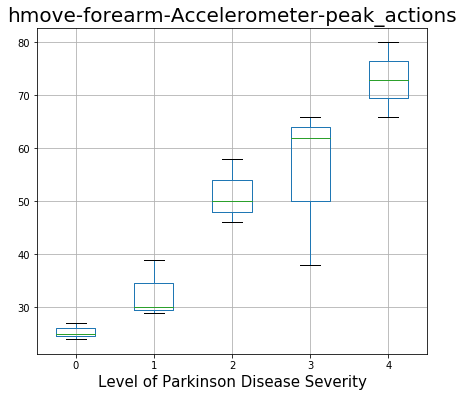

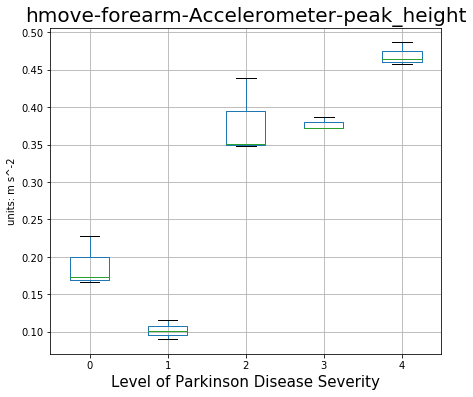

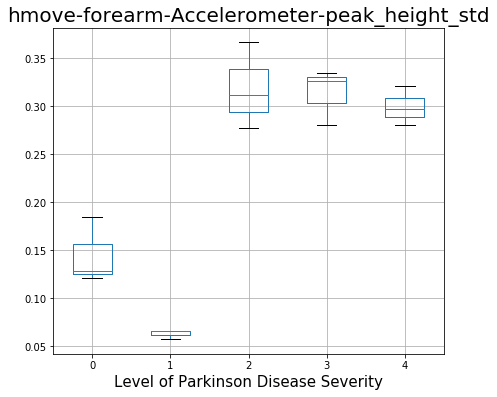

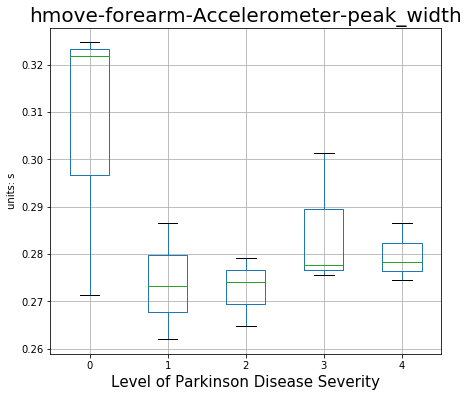

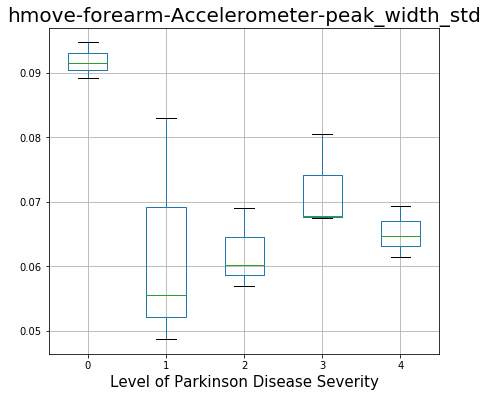

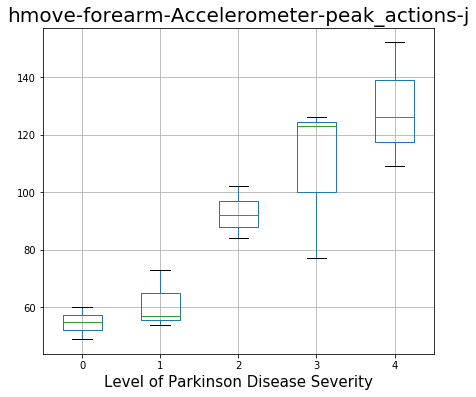

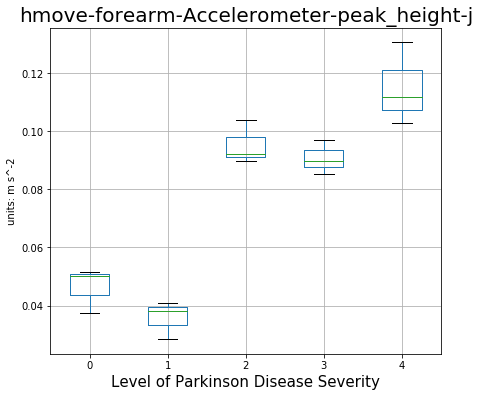

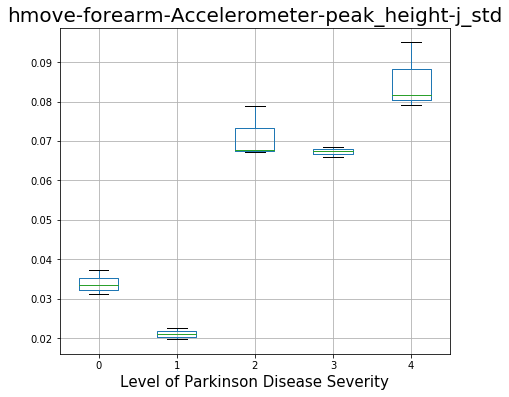

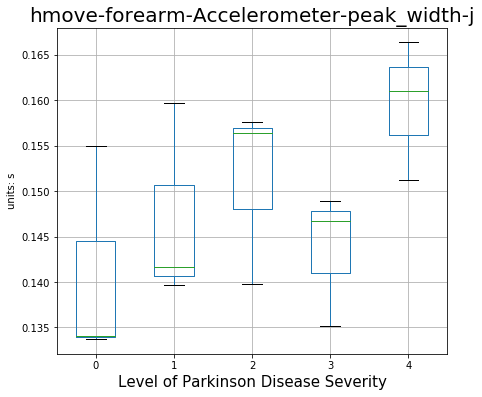

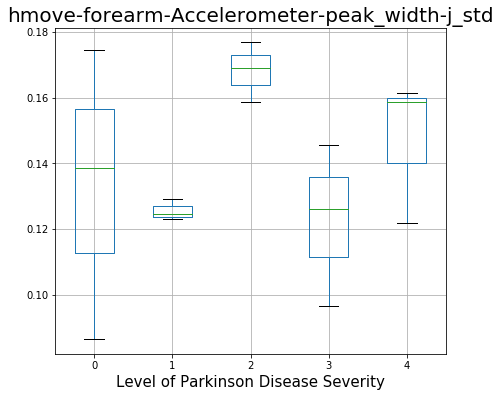

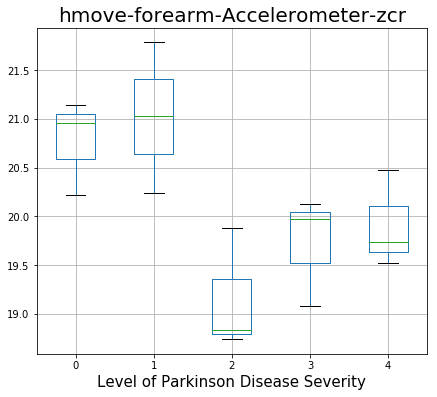

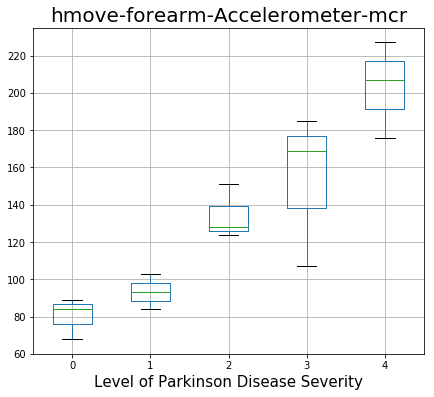

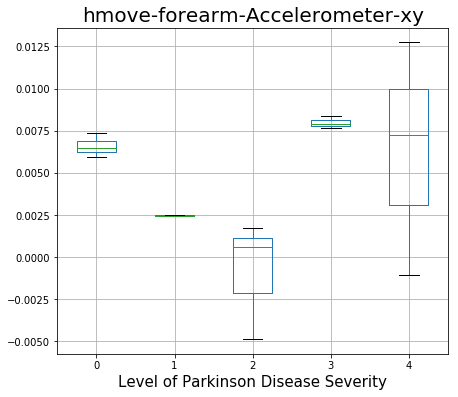

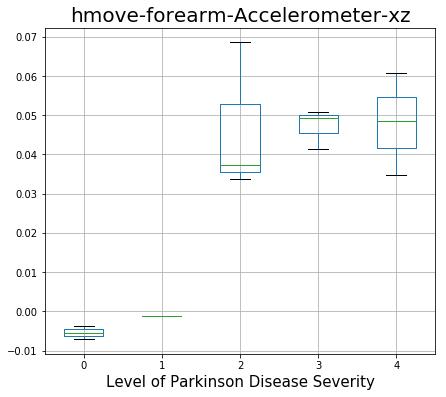

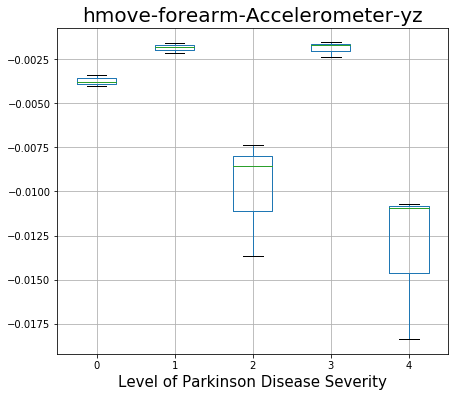

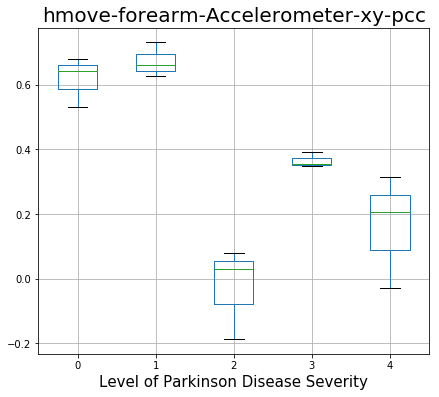

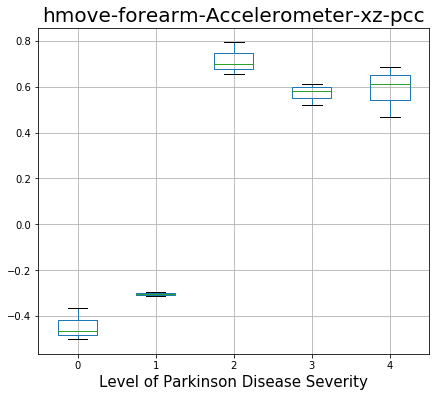

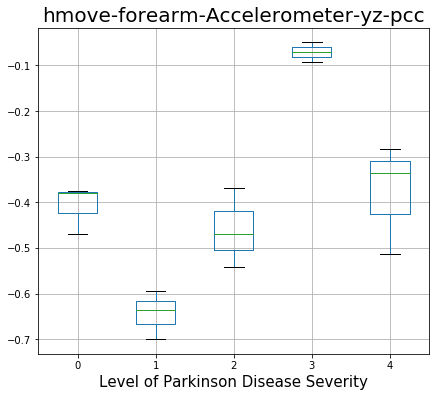

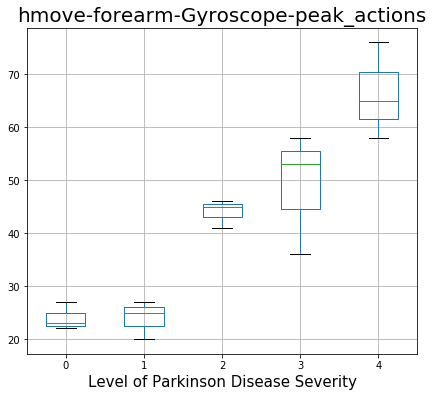

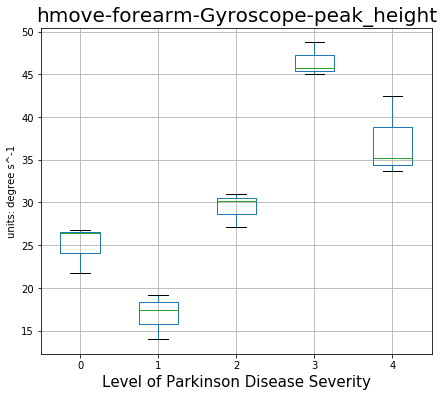

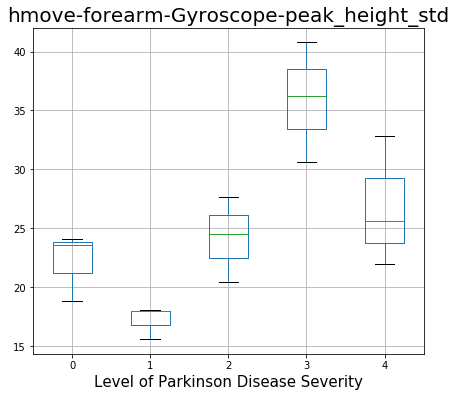

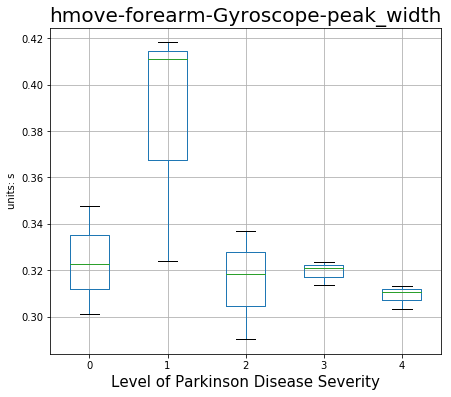

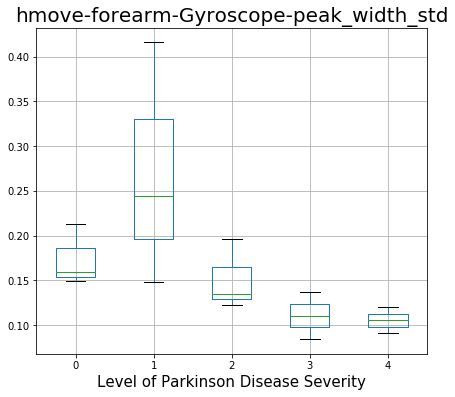

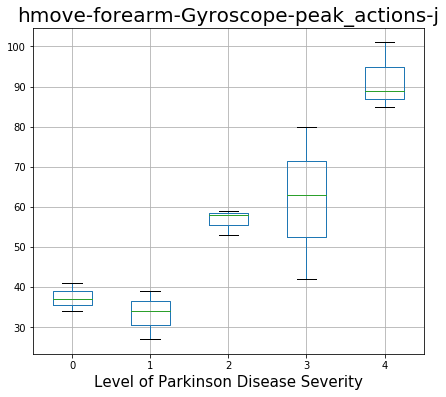

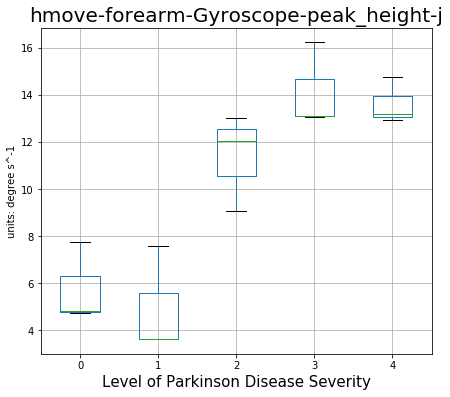

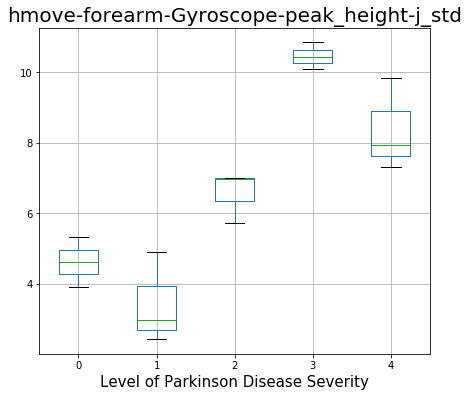

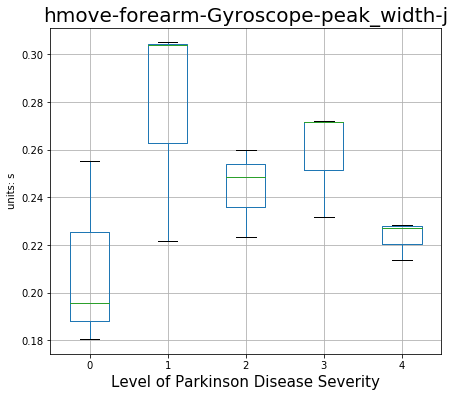

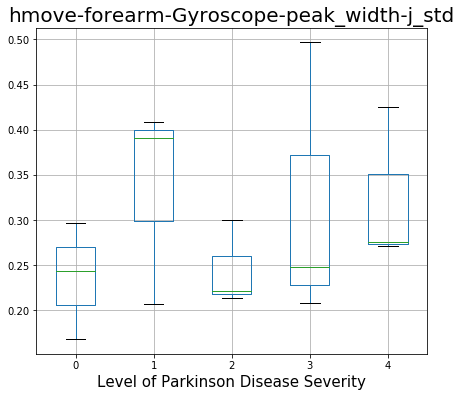

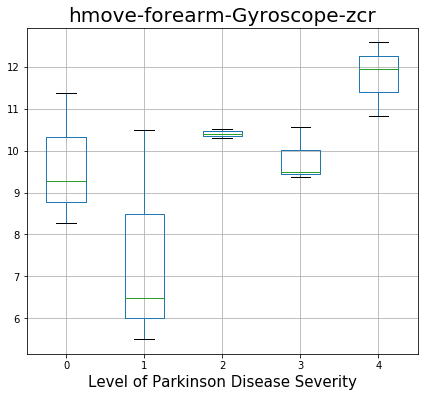

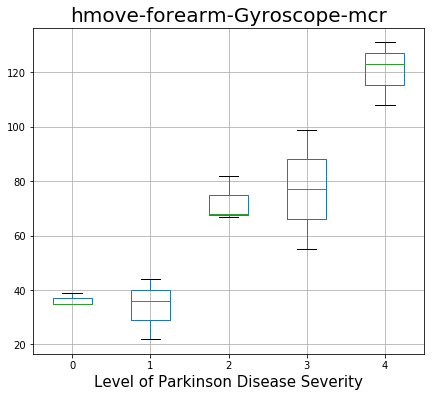

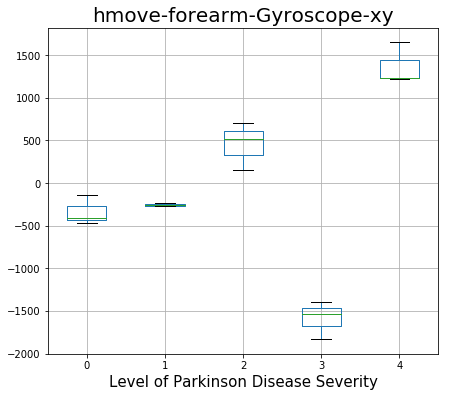

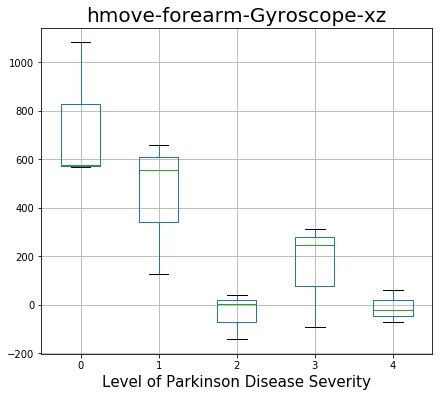

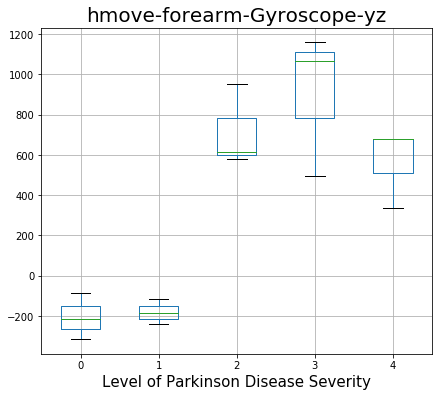

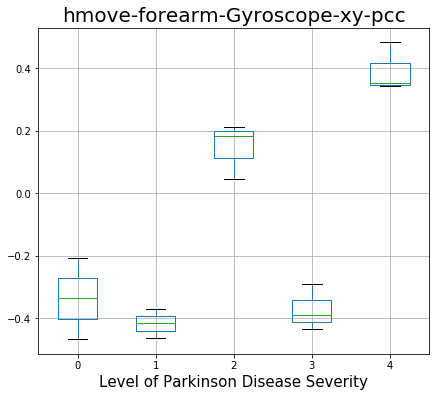

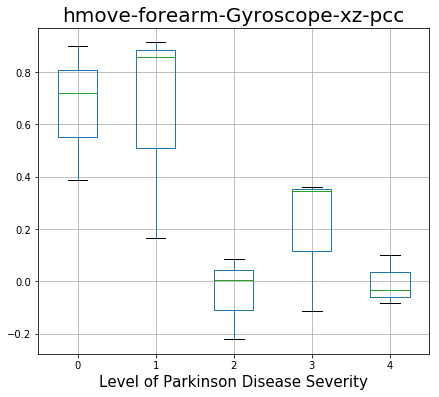

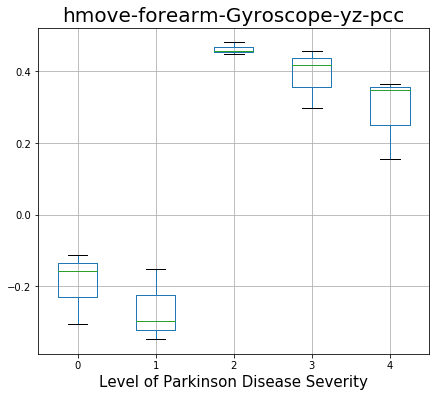

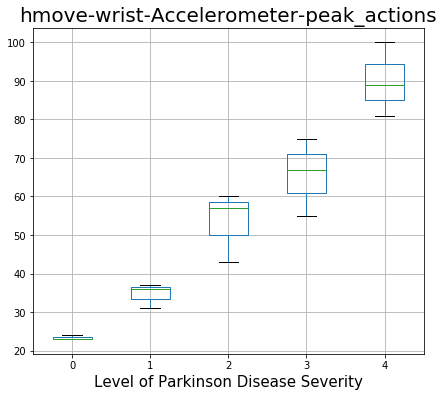

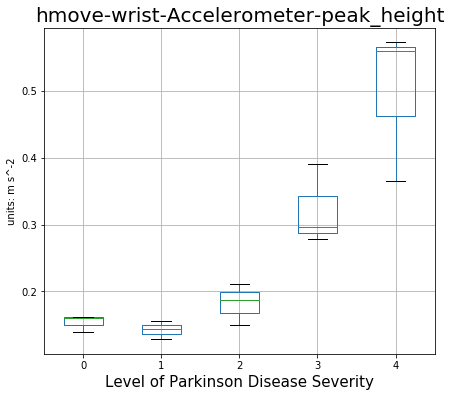

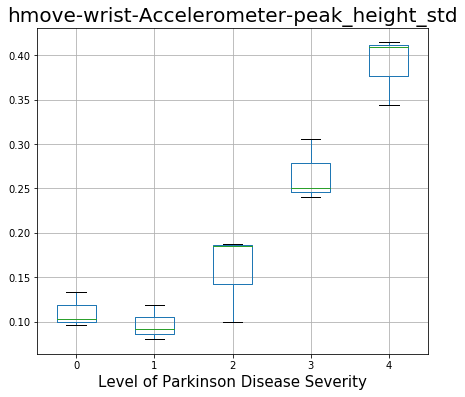

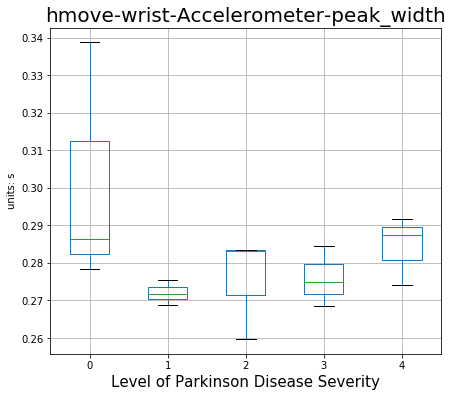

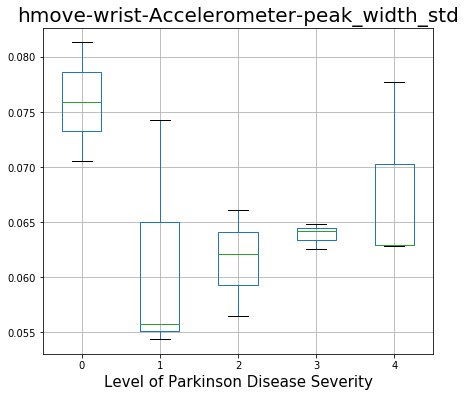

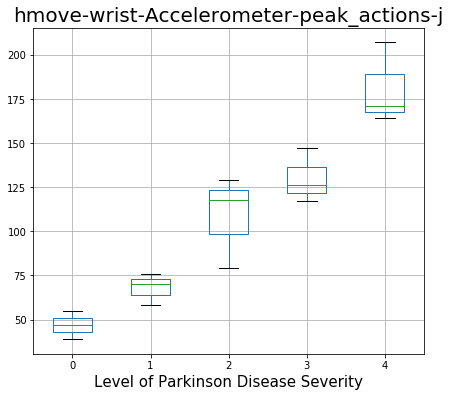

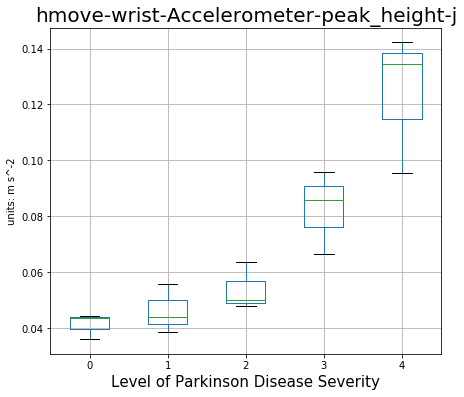

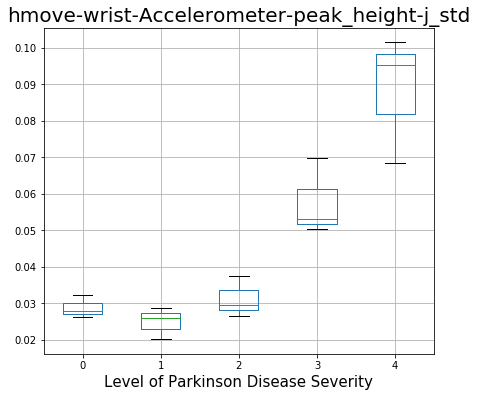

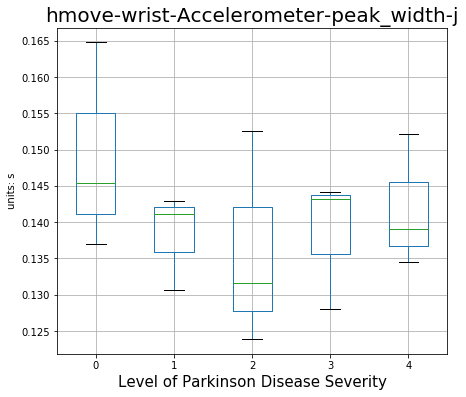

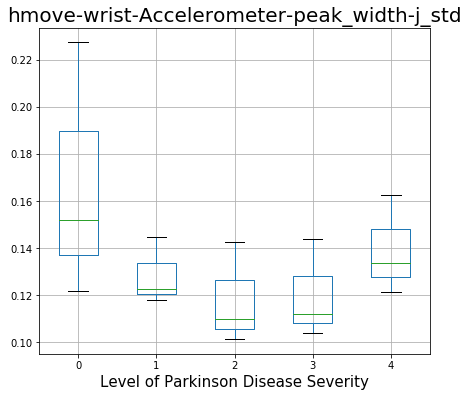

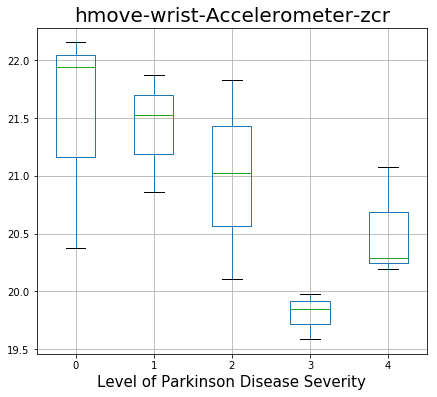

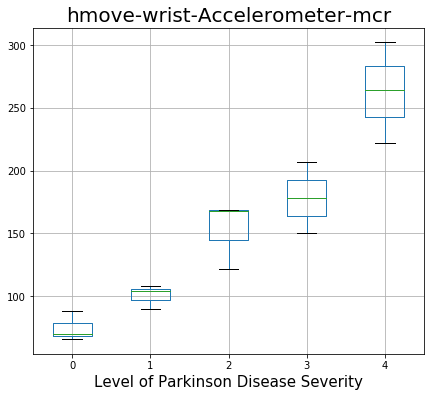

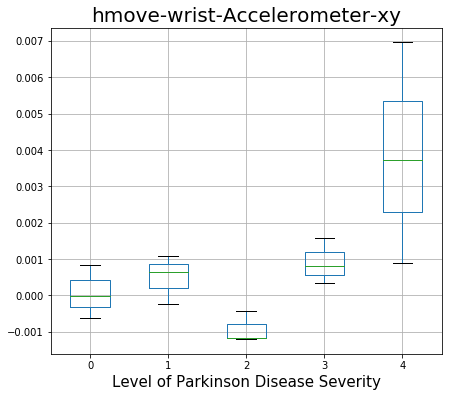

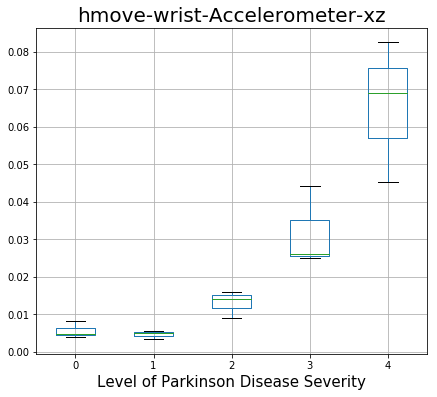

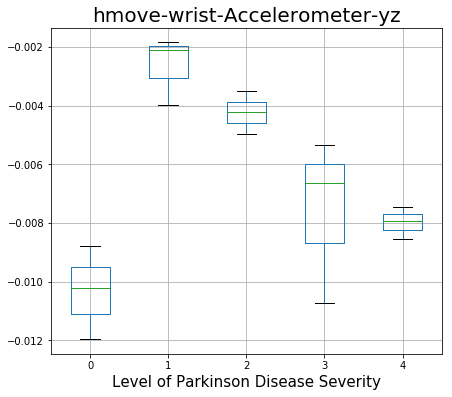

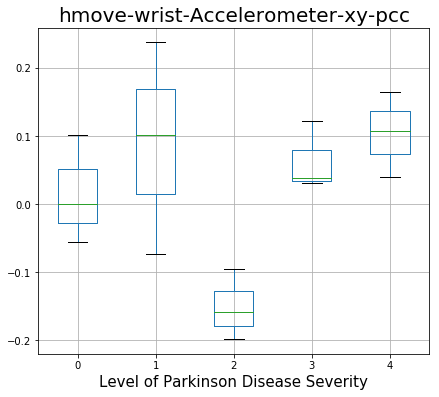

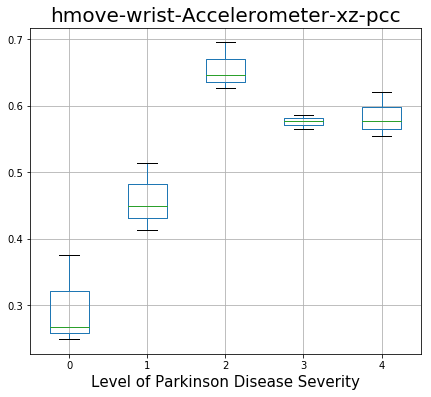

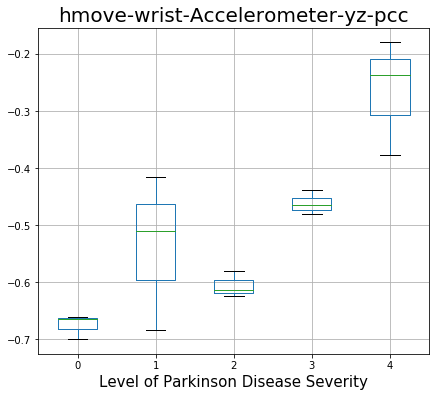

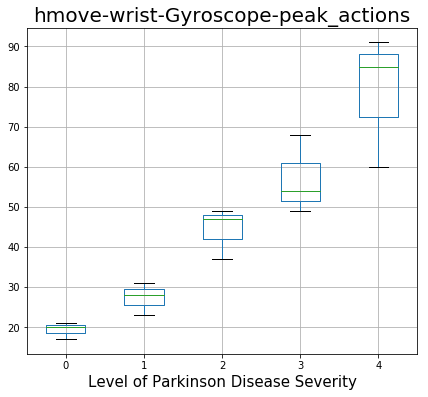

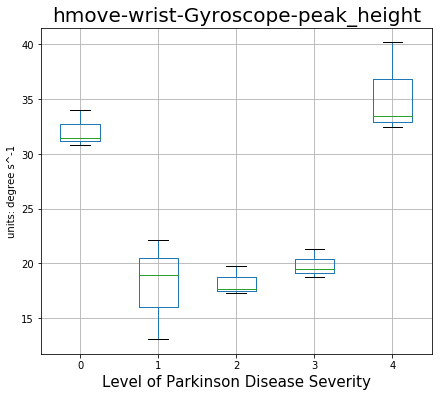

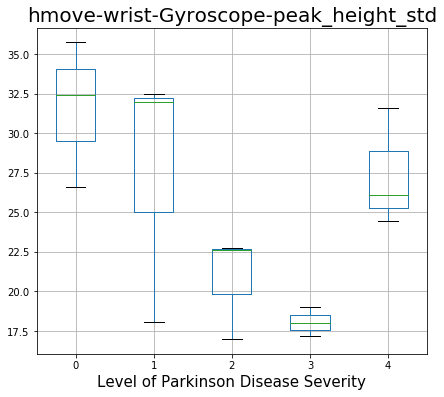

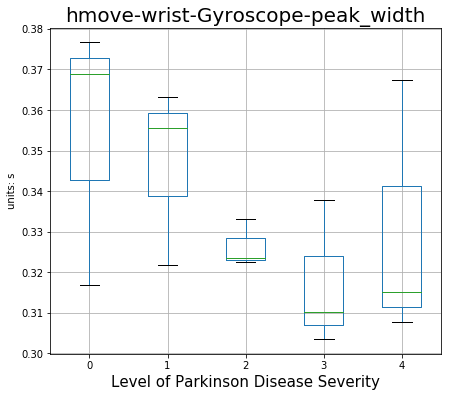

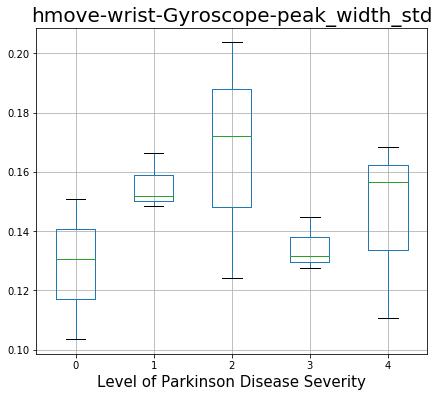

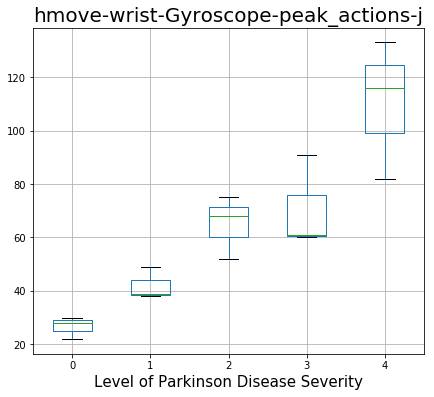

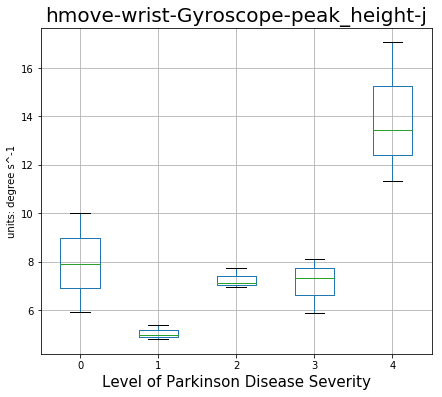

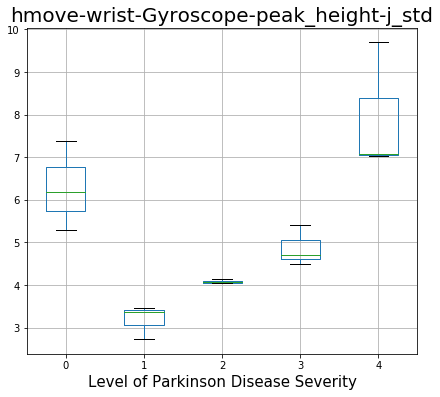

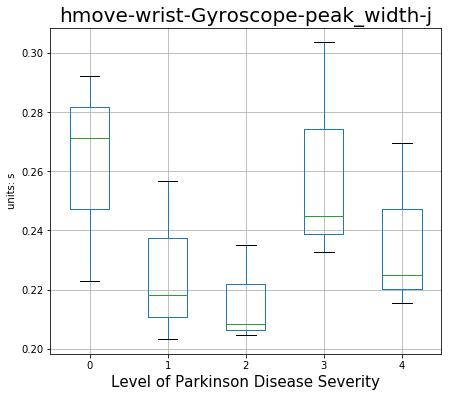

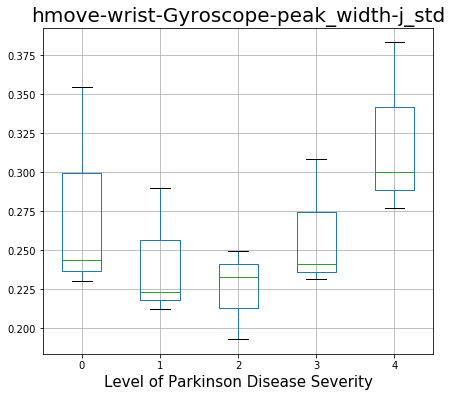

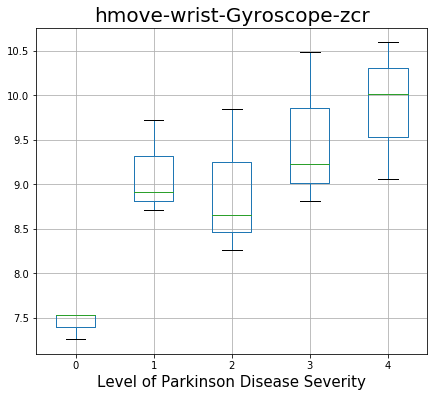

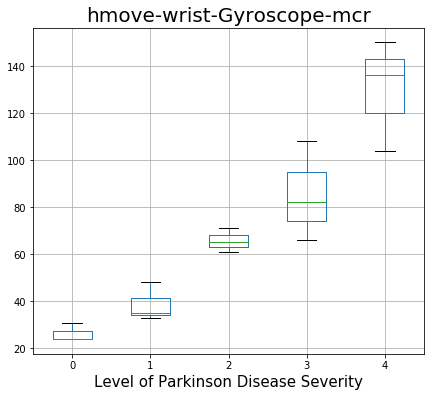

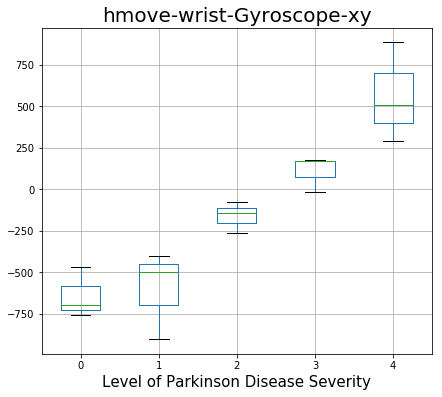

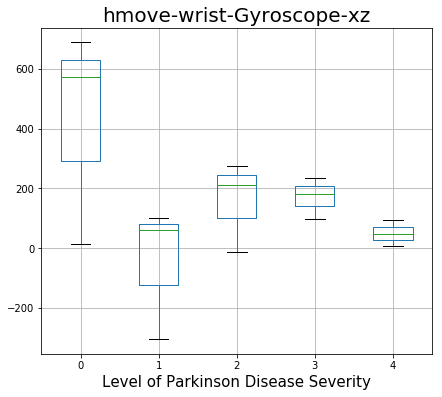

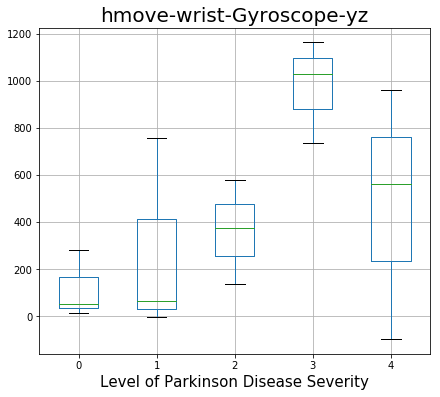

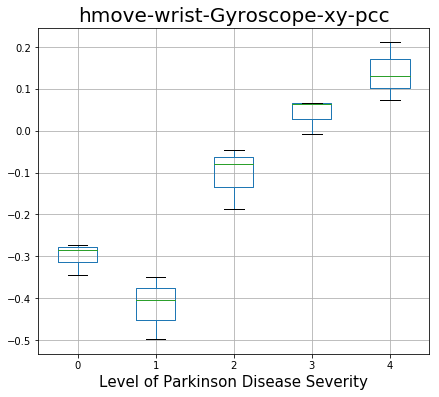

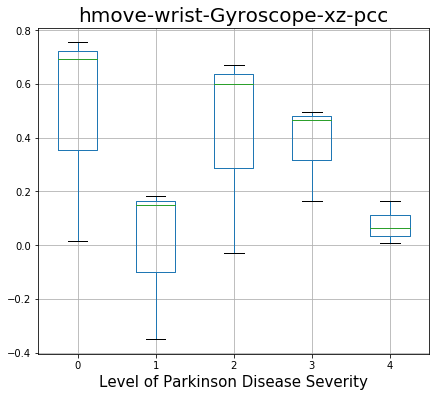

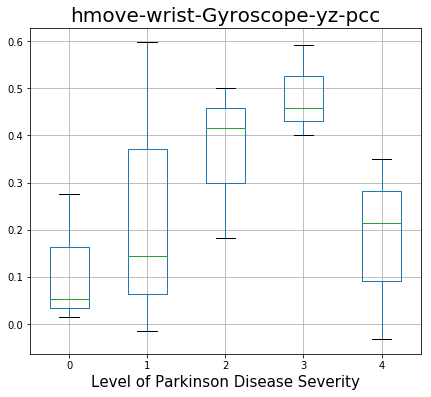

In [14]:
for key in data:
    if 'hmove' in key:
        newdf = data[key]['x'].tolist()
        newdf = np.reshape(newdf, (5, 3)).T
        df = pd.DataFrame(newdf, columns=list('01234'))
        ax = df.plot.box(figsize=(7,6), title=key.replace('_','-').replace(' ','_'), grid=True)
        ax.title.set_size(20)
        ax.set_xlabel("Level of Parkinson Disease Severity", {'fontsize': 15})
        
        if data[key].loc[0,'x_unit'] is not '-':
            ax.set_ylabel("units: " + data[key].loc[0,'x_unit'])
            
#         plt.savefig('res/' + key.replace(' ','_') + '.png')